In [28]:
import random
import numpy as np
import string
import matplotlib.pyplot as plt
from keras.models import Sequential, load_model
from keras import layers


In [29]:
alphabet = list('abcdefghijklmnopqrstuvwxyz-')
values = ['.-', '-...', '-.-.', '-..', '.', '..-.', '--.', '....', '..', '.---', '-.-', 
          '.-..', '--', '-.','---', '.--.', '--.-', 
          '.-.', '...', '-', '..-', '...-', '.--', '-..-', '-.--', '--..','-....-']

morse_dict = dict(zip(alphabet, values))
ascii_dict = dict(map(reversed, morse_dict.items())) # inverse mapping

# convert text to morse code
def morse_encode(text):
    t = ''.join([c for c in text.lower() if c in alphabet])
    return ' '.join([''.join(morse_dict[i]) for i in t])
 
# convert morse code to text
def morse_decode(code):
    return ''.join([ascii_dict[i] for i in code.split(' ')])

In [30]:
word_len = 6                                    # number of characters output

max_len_x = len(max(values, key=len))*word_len+(word_len-1)  # number of morse symbols
max_len_y = word_len
    
# generate data for training 

def generate_data (n):
    output_list = [(''.join([random.choice(string.ascii_lowercase + '-') 
        for _ in range(word_len)])) 
            for _ in range(n)]
    return  output_list, [morse_encode(s) for s in output_list]
    
output_list, input_list = generate_data(10000)

In [31]:
class Embedding(object):
    def __init__(self, chars):
        self.chars = sorted(set(chars))
        self.char_indices = dict((c, i) for i, c in
                                            enumerate(self.chars))
        self.indices_char = dict((i, c) for i, c in 
                                            enumerate(self.chars))
    def encode(self, token, num_rows):
        x = np.zeros((num_rows, len(self.chars)))   # zeros, except ..
        for i, c in enumerate(token):               # one 
            x[i, self.char_indices[c]] = 1
        return x
    
    def decode(self, x):
        x = [x.argmax(axis=-1)]
        return ''.join(self.indices_char[int(v)] for v in x)
    

In [32]:
# character sets used at input (morse code) and output (text)

chars_in = '-. '
chars_out = ''.join(alphabet)

embedding_in = Embedding(chars_in)
embedding_out = Embedding(chars_out)

# x : input to encoder, y : output from decoder
x = np.zeros((len(input_list), max_len_x, len(chars_in)))
y = np.zeros((len(output_list), max_len_y, len(chars_out)))

for i, token in enumerate(input_list):
    x[i] = embedding_in.encode(token, max_len_x)
    
for i, token in enumerate(output_list):
    y[i] = embedding_out.encode(token, max_len_y)
    
# split data set : 3/4 for training, 1/4 for evaluation
m = 3*len(x)// 4
(x_train, x_val) = x[:m], x[m:]
(y_train, y_val) = y[:m], y[m:]

# show some examples ...
for i in range(5):
    print(''.join([embedding_in.decode(token) for token in x_train[i]]),
          ''.join([embedding_out.decode(token) for token in y_train[i]]))

..- .-. -....- . -.- -                    ur-ekt
--- -- -..- --.- -. ....                  omxqnh
-- --. .-. --. --.. --..                  mgrgzz
-.. ...- -.- -. --.. --..                 dvknzz
.--- ... -... .--. --.. .---              jsbpzj


In [33]:
latent_dim = 200

model = Sequential()
model.add(layers.LSTM(latent_dim, input_shape=(max_len_x,len(chars_in))))
model.add(layers.RepeatVector(max_len_y))
model.add(layers.LSTM(latent_dim, return_sequences=True))
model.add(layers.TimeDistributed(layers.Dense(len(chars_out))))
model.add(layers.Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', 
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 200)               163200    
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 6, 200)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 6, 200)            320800    
_________________________________________________________________
time_distributed_2 (TimeDist (None, 6, 27)             5427      
_________________________________________________________________
activation_2 (Activation)    (None, 6, 27)             0         
Total params: 489,427
Trainable params: 489,427
Non-trainable params: 0
_________________________________________________________________


Epoch 1/50
750/750 [==============================] - 13s 17ms/step - loss: 3.1236 - accuracy: 0.0799 - val_loss: 3.0107 - val_accuracy: 0.0980
Epoch 2/50
750/750 [==============================] - 13s 17ms/step - loss: 2.9482 - accuracy: 0.1160 - val_loss: 2.9035 - val_accuracy: 0.1289
Epoch 3/50
750/750 [==============================] - 13s 18ms/step - loss: 2.7400 - accuracy: 0.1668 - val_loss: 2.5818 - val_accuracy: 0.2167
Epoch 4/50
750/750 [==============================] - 14s 19ms/step - loss: 2.4822 - accuracy: 0.2370 - val_loss: 2.3763 - val_accuracy: 0.2631
Epoch 5/50
750/750 [==============================] - 14s 19ms/step - loss: 2.2760 - accuracy: 0.2909 - val_loss: 2.1047 - val_accuracy: 0.3268
Epoch 6/50
750/750 [==============================] - 14s 19ms/step - loss: 2.0277 - accuracy: 0.3617 - val_loss: 1.9130 - val_accuracy: 0.4002
Epoch 7/50
750/750 [==============================] - 15s 20ms/step - loss: 1.8672 - accuracy: 0.4137 - val_loss: 1.8794 - val_accuracy:

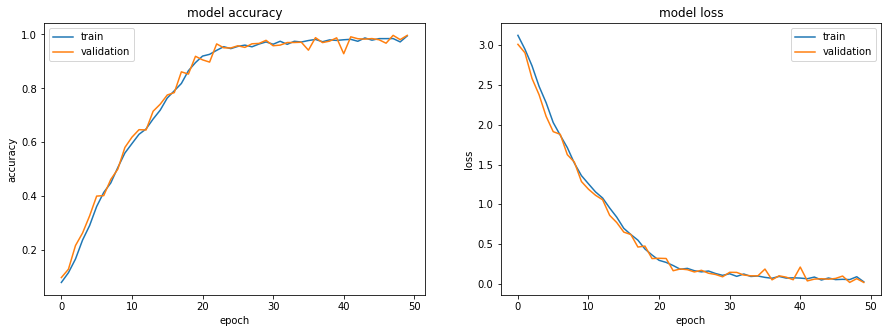

In [34]:
Epochs = 50
Batch_size = 10

# train
hist = model.fit(x_train, y_train, 
                 batch_size=Batch_size, epochs=Epochs, 
                 validation_data=(x_val, y_val))

#show history of progress
def show_progress():
    plt.figure(figsize=(15,5))
    plt.subplot(121)
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.subplot(122)
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()

show_progress()

In [35]:
test = ['abcdef', '-hslu-','hahaha','------','xyzuvw','pipapo','hello-','world-']
        
x = np.zeros((len(test), max_len_x, len(chars_in)))
for i, token in enumerate(test):
    x[i] = embedding_in.encode(morse_encode(token), max_len_x)

pre = model.predict(x)

for i in range(len(test)):
    print(''.join([embedding_in.decode(code) for code in x[i]]),
          ''.join([embedding_out.decode(code) for code in pre[i]]), ' <-> ', 
          ''.join(test[i]))

.- -... -.-. -.. . ..-.                   abcdef  <->  abcdef
-....- .... ... .-.. ..- -....-           -hslu-  <->  -hslu-
.... .- .... .- .... .-                   hahaha  <->  hahaha
-....- -....- -....- -....- -....- -....- ----hs  <->  ------
-..- -.-- --.. ..- ...- .--               xyzuvw  <->  xyzuvw
.--. .. .--. .- .--. ---                  pipapo  <->  pipapo
.... . .-.. .-.. --- -....-               hello-  <->  hello-
.-- --- .-. .-.. -.. -....-               world-  <->  world-
